# Collaborative Filtering Recommenders

Collaborative filtering is a recommendation method based on nearest-neighbors. It is commonly used in recommender systems in practice because of its simplicity and efficiency in producing good results.

In this notebook, you'll learn how collaborative filtering works and see examples of its application. You'll also get to know (or remeber!) SciPy's sparse matrices, which can be very handy with big datasets.

In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

MOVIES_FILE = '../data/movies.csv'

## 1 Two classical recommendation problems that we can solve with collaborative filtering

### 1.1 Best item problem

In the best item problem, we're trying to recommend to a user the new item that he will be most interested in.

For instance, in the context of movie recommendations, where users rate movies (explicit feedback), this problem consists in predicting the rating that a user would give to each unseen movie and then suggesting him the movie for which we predicted the highest rating.

When evaluating a model that tries to solve this problem, we need to measure the error of our predictions by comparing them with their true values.
Evaluation metrics that can be used in this problem are:
* [Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error): what's the difference between our predicted rating and the rating that the user really gave to the movie, averaged over all predictions
* [Root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation): 


### 1.2 Top N items problem

In this problem, we're trying to find the list of N items that the user will have most interest to interact with.

For instance, in online marketplaces, like Amazon, it's common to study the users' interactions with the products in terms of clicks (implicit feedback). So, in this case, the top N items problem consists in selecting the list of items that the user will most likely click in.

Evaluation metrics that can be used in this problem are:
* [Precision](https://en.wikipedia.org/wiki/Precision_and_recall#Precision): how many items in the top N did the user click in
* [Recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall): how many items that had clicks were in the top N
* [Mean average precision](https://en.wikipedia.org/wiki/Information_retrieval#Mean_average_precision): same idea as precision, but accounting for the order of the items in the top N

## 2. Intuition on collaborative filtering methods


In a very high level way, and using the movies scenario, there are two ideas behind collaborative filtering:
- If two people usually like the same movies and dislike the same movies, then they will probably feel the same way about a new movie
- If many people feel the same way about two movies, then the two movies are probably similar; a user that has only watched one of the movies and liked it will probably like the other movie too

Now, let's dig into each of them!

### 2.1 User based method

The first idea presented above corresponds to the user based method of collaborative filtering.

In this method, when we're trying to recommend an item to a user _u_, we start by finding _u_'s nearest neighbors among the other users, which are the users that interact with items in the same way as _u_ does.
Then, we use the nearest neighbors' ratings to predict _u_'s ratings for unseen movies. Finally, the recommended movie will be the one with the highest predicted rating.

For example, considering this ratings table, we are trying to recommend a movie for Alice to watch:

In [ ]:
df = pd.read_csv(MOVIES_FILE, index_col=0)
df

We can see that both Alice and Bob seem to like science fiction movies and dislike musicals. With Cate it's the oposite, Dylan has an eclectic taste and Eva maybe dislikes old movies.
So, we can say that for Alice, Bob is her most similar neighbor, followed by Eva and Dylan. And Cate is the least similar one.

##### Similarity measures

But how do we measure the actual similarities between the users?
Many possible solutions:
* [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)
* [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
* [Spearman rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

Let's use pearson correlation to compute the similarity between each pair of users:

In [ ]:
# reading the dataframe again in order to treat the - as Nan
df = pd.read_csv(MOVIES_FILE, index_col=0, na_values='-')
S = df.corr()
S

And let's scale the similarity values from 0 to 1 (this is to guarantee that our recommendation will have the same scale as the user ratings):

In [ ]:
def scale_correlation_matrix(S):
    S_min = S.min().min()
    S_max = S.max().max()
    return (S - S_min) / (S_max - S_min)


S = scale_correlation_matrix(S)
S

Now let's predict Alice's ratings for the unseen movies "Singing in the rain" and "Interstellar".

For this, we'll use the following equation, which basically says that the predicted rating for an item is the average of the nearest neighbors' ratings, weighted by the similarities between the user and the neighbors:


\begin{equation*}
r_{ui}' = \frac{\sum_{v \in N_i(u)} w_{uv} r_{vi}}{\sum_{v \in N_i(u)} |w_{uv}|}
\end{equation*}

$r_{ui}'$: _predicted rating from user u to item i_

$N_i(u)$: _nearest neighbors of user u that have rated item i_

$w_{uv}$: _similarity between users u and v_

$r_{vi}$: _rating given by user v to item i_

In [ ]:
alice_similarities = S.loc['Alice'].drop('Alice')

singing_in_the_rain = df.loc['Singing in the rain'].drop('Alice')
r_singing_in_the_rain = np.average(singing_in_the_rain, weights=alice_similarities)

interstellar = df.loc['Interstellar'].drop('Alice')
r_interstellar = np.average(interstellar, weights=alice_similarities)

print('* "Singing in the rain" predicted rating: {}'.format(round(r_singing_in_the_rain, 2)))
print('* "Interstellar"        predicted rating: {}'.format(round(r_interstellar, 2)))

So, the best recommendation we can give to Alice is for her to watch "Interstellar" (and not to watch "Singing in the rain", since she'll probably hate it!).

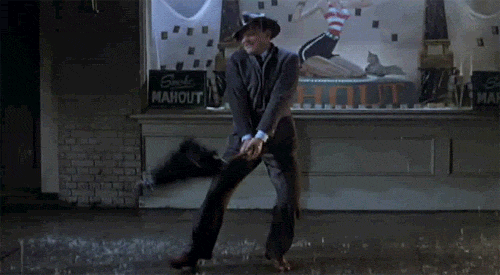

### 2.2 Item based method

The item based approach follows the second idea that we presented above.

In this case, we will use similarities between items, instead of between users.
And to predict the rating that user _u_ gave to item _i_, we'll use the average of the ratings that user _u_ gave to the items most similar to _i_, weighted by the similarities between items.

The equation for the model is, in this case:


\begin{equation*}
r_{ui}' = \frac{\sum_{j \in N_u(i)} w_{ij} r_{ui}}{\sum_{j \in N_u(i)} |w_{ij}|}
\end{equation*}

$r_{ui}'$: _predicted rating from user u to item i_

$N_u(i)$: _nearest neighbors of item i that user u has rated_

$w_{ij}$: _similarity between items i and j_

$r_{ui}$: _rating given by user u to item i_


Let's see this case with our example:

In [ ]:
# we're transposing the dataframe in order to compute correlations between the columns (movies)
df_items = df.transpose()
S = df_items.corr(method='pearson', min_periods=1)
S = scale_correlation_matrix(S)
S

In [ ]:
alice_ratings = df[['Alice']].dropna()
alice_movies = alice_ratings.index
alice_ratings = alice_ratings.Alice.values

singing_in_the_rain_similarities = S.loc[alice_movies, 'Singing in the rain'].values
r_singing_in_the_rain = np.average(alice_ratings, weights=singing_in_the_rain_similarities)

interstellar_similarities = S.loc[alice_movies, 'Interstellar'].values
r_interstellar = np.average(alice_ratings, weights=interstellar_similarities)

print('* "Singing in the rain" predicted rating: {}'.format(round(r_singing_in_the_rain, 2)))
print('* "Interstellar"        predicted rating: {}'.format(round(r_interstellar, 2)))

With this method, we are not so reluctant in recommending "Singing in the rain" to Alice!

### 2.3 User based vs Item based

When should each method be used?

* If our system has much __more users than items, go for item based__ (and vice-versa). Computing similarities is probably the most expensive operation you'll be doing, thus do it in the smaller set.

* If your items are more stable than users, i.e, if you __add users more frequently than items, go for item based__ (and vice-versa). You'll want to recompute the similarities matrix as least as possible (while keeping accurate results, of course!)

* Do you need [__serendipity__](https://en.wikipedia.org/wiki/Serendipity)? If yes, go for __user based__. When you use item based, given that the results are based on the user's own actions, the results will be less surprising for him.

* Do you need to __justify your recommendations__? If yes, go for __item based__. It's easier to justify a recommendation with: "We're showing you this because you liked that" than with: "We're showing you this because Jon Doe (who you don't know!) also liked it and your tastes are very similar".

### 2.4 Evaluation

Now imagine that ended up recommending both movies to Alice and after she watched them, she gave us her rating:
* Singing in the rain => 3
* Interstellar => 5

With the true results, we can compute the RMSE to evaluate our recommendations, for both the methods.

In [ ]:
y_true = [3, 5]

# User based
y_pred = [2.33, 5]
print('* User based RMSE = {}'.format(round(sqrt(mean_squared_error(y_true, y_pred)), 4)))

# Item based
y_pred = [3, 3.43]
print('* Item based RMSE = {}'.format(round(sqrt(mean_squared_error(y_true, y_pred)), 4)))

## 3 What changes when we have implicit feedback instead of ratings?

As we said above, with implicit feedback we don't have user ratings for the items. Instead we have data that measures the interaction of a user with an item.
These are examples of data that can be used as implicit feedback for a recommender system:
* clicks on the search of a classified advertising website
* page views on a news website
* video playcounts in an video sharing website

One big challenge of implicit feedback data, is that it only measures if the user interacted with the item and not how much did the user like the item.
A way to deal with this is to find proxy metrics that describe how much a user liked an item in terms of data that describe interactions.

For instance, in the news website, we may try to interpret a page view where the user spent a long time as the user having a high preference for that item. Of course that one should test this kind of hypothesis before using them in a model.

## 4 SciPy sparse matrices

A sparse matrix is a big matrix where most of its elements are 0.
Handling very big data structures in our laptops can be a pain, since they have limited memory and processing power.
So, the smart people who build math libraries (like [SciPy](https://docs.scipy.org/doc/scipy/reference/sparse.html)), developed the sparce matrices data structures.

Basically the idea behind sparce matrices is to just store the information relative to the non-zero elements of the matrix.
This makes working with these matrices way easier and faster than if we used regular Numpy matrices or Pandas.

We'll start this section with some concepts regarding sparce matrices and then we'll see a practical example, which is to compute cosine similarities between items using a sparse matrix.

There are several types of sparse matrices, some of which are:

##### [coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix)
Matrix in the coordinates format.

__+__ it's a fast format for constructing sparse matrices

__-__ doesn't directly support arithmetic operations or slicing, so requires conversion to other formats

##### [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix)
Compressed sparse column matrix.

__+__ efficient arithmetic operations (CSC + CSC, CSC * CSC, etc.)

__+__ efficient column slicing

__-__ slow row slicing operations (consider CSR)

__-__ changes to the sparsity structure are expensive (consider LIL or DOK)

##### [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)
Compressed sparse row matrix.

__+__ efficient arithmetic operations CSR + CSR, CSR * CSR, etc.

__+__ efficient row slicing

__+__ fast matrix vector products

__-__ slow column slicing operations (consider CSC)

__-__ changes to the sparsity structure are expensive (consider LIL or DOK)

##### [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix)
Row-based linked list sparse matrix.

__+__ supports flexible slicing

__+__ changes to the matrix sparsity structure are efficient

__-__ arithmetic operations LIL + LIL are slow (consider CSR or CSC)

__-__ slow column slicing (consider CSC)

__-__ slow matrix vector products (consider CSR or CSC)

##### Example

In this example we'll compute the top 20 recommended items for a user.
We'll use the Movielens dataset, which was already used in the Content based notebook.

Let's start by reading the data into a pandas DataFrame.

In [ ]:
df = pd.read_csv('../data/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
df.head()

Then, we'll convert the DataFrame into a sparse matrix where the rows are items, the columns are users, and each value of the matrix corresponds to the rating that user j (column) gave to item i (row).

We'll use the coo_matrix because it allows to efficiently build the sparse matrix from data in ijv form (i is the row, j is the column and v is the value).

In [ ]:
row  = np.array(df.item_id.values)
col  = np.array(df.user_id.values)
data = np.array(df.rating.values)
m = coo_matrix((data, (row, col)), shape=(df.item_id.max()+1, df.user_id.max()+1))
m.toarray()

Let's compute the density of the matrix, just to know what we're dealing with :)

In [ ]:
# get the number of non-zero values
nnz = m.nnz

# get the matrix shape
shape = m.shape

# the number of elements in the matrix is n_rows * n_cols
n_elems = shape[0] * shape[1]

# the density of the matrix is the number of non-zero elements over all the elements
print('Density of sparse matrix: {}%'.format(round(nnz/n_elems*100, 2)))

The next step is to compute item similarities. For that, we'll use scikit's [cosine_similarity](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html). This method can return the result in form of a sparse matrix (csr_matrix) by setting the dense_output flag to False.

In [ ]:
S = cosine_similarity(m, dense_output=False)
print(type(S))
print('Matrix density: {}%'.format(round(S.nnz/(S.shape[0] * S.shape[1]), 2)))
S.toarray()

Now, we'll select the user column for user 1.
Since we're doing a slice operation on the matrix's columns, we'll first convert the coo_matrix into a csc_matrix.

In [ ]:
user = m.tocsc()[:,1]
print(type(user))
user.toarray()

Now, we'll find the product between matrix S and the user vector. This will give us the preference that the user has for each item.

Attention! These are not the predicted ratings that the user will give to the items, like in the examples above! Instead, the preferences vector has values that will allow us to order the items in terms of the user's preference towards them.

In [ ]:
preferences = S.dot(user)
print(type(preferences))
preferences.toarray()

The next step is to remove from the preferences vector the movies that the user has already watched.
For this, we'll transform the user vector into a coo_matrix and get the indexes for which the vector has values.
These are the indexes that we want to set to 0 in the preferences vector.

In [ ]:
user_coo = user.tocoo()

for i, j in zip(user_coo.row, user_coo.col):
    preferences[i, j] = 0

preferences.toarray()

Finally we'll convert the preferences vector back to a pandas DataFrame and select the top 20 most preferred items.

In [ ]:
df_preferences = pd.DataFrame(preferences.toarray(), columns=['user_1'])
df_preferences = df_preferences[df_preferences.user_1 > 0].sort_values('user_1', ascending=False)
df_preferences.head(20).index.values